# Analysis of Human Dynamics - Coursework
Student number: 201411241  
Word count: 2287 (excluding outputs, references and appendices)
  
## Can socio-demographic compositions of LSOAs predict crime rates?

Crime rates are frequently linked to socio-demographic variables, including alcohol consumption (de Vocht et al., 2016), socio-economic deprivation (Eberts and Schwirian, 1968), and health (Kawachi et al., 1999). Moreover, UK-based research suggests that violent crime is linked to population density, deprivation, population movements and ethnic heterogeneity of an area (Tarling and Dennis, 2016). Using UK Census (ONS, 2011; 2016) and police data (UK Crime Stats, nd) both from the year 2011, the current analysis aims to explore relationships between socio-demographic variables and rates of violent and sexual offences in Greater Manchester in depth.  

In [1]:
#Import libraries and data
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split 
import statsmodels.formula.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

crime_data=pd.read_csv('crime_data/man_cr_med.csv').set_index('lsoa')
all_data=pd.read_csv('data/manchester_data.csv').set_index('GEO_CODE').join(crime_data, how='left')

la_data=pd.read_csv('shapefiles/manlsoala.csv').set_index('geo_code')
lsoa_data=gpd.read_file('shapefiles/man_lsoa_all.shp').set_index('geo_code').join(la_data, how='left')

### Pre-process data

First, the data needs to be pre-processed. Distributions of variables are visually analysed.

With the exceptions of age and crime count, variables display the fraction of people or households in an LSOA within a certain category (bad or very bad health, central heating, not deprived in any category, deprived in at least 2/3/4 categories, student households, one-family households, no access to cars or vans, ethnic diversity (HHI), people identifying as ethnically white).  


In [2]:
all_data.head()

,age_mean,age_median,badhealth,centheat,nodepr,depr_4+,depr_3+,depr_2+,studenthhold,onefam_hhold,nocars,eth_hhi,ethwhite,vi_crime_count
GEO_CODE,,,,,,,,,,,,,,
E01004766,42.10929,42.0,0.075377,0.937107,0.350943,0.002516,0.051572,0.298113,0.001258,0.510692,0.354717,0.176145,0.863693,31.0
E01004767,40.15316,39.0,0.048868,0.958333,0.446615,0.003906,0.046875,0.221354,0.010417,0.558594,0.244792,0.172369,0.796782,39.0
E01004768,39.94941,42.0,0.016864,0.991736,0.641322,0.000000,0.008264,0.084298,0.000000,0.796694,0.044628,0.221215,0.937539,7.0
E01004769,41.63690,42.5,0.035202,0.982482,0.554745,0.001460,0.016058,0.138686,0.000000,0.645255,0.132847,0.197436,0.930248,17.0
E01004770,44.31058,45.0,0.055290,0.978896,0.452922,0.001623,0.022727,0.194805,0.000000,0.733766,0.144481,0.136553,0.822526,13.0


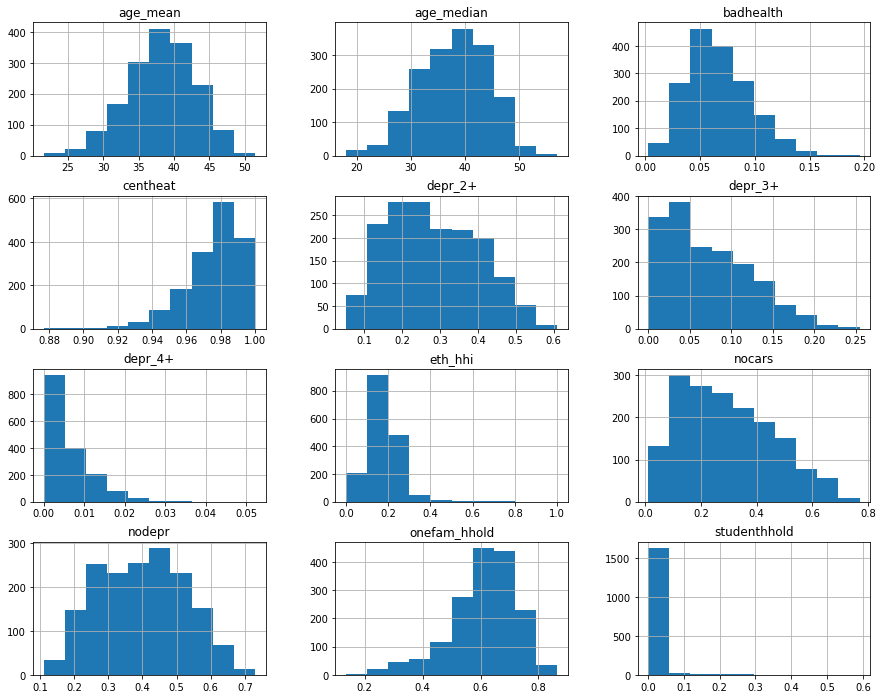

In [3]:
#Visually analyse distributions of variables to be used
all_data.drop(['vi_crime_count','ethwhite'], axis=1).hist(figsize=(15,12))
plt.show()

  
Median age is chosen as it is less affected by very young and very old residents than mean age (though distributions appear similar). Moreover, fraction of households deprived in at least 2 categories (depr_2+) appears to have a more normal distribution than 3 (depr_3+) or 4 (depr_4+) categories and may contain a better estimate of high deprivation than fraction of households deprived in no category (nodeprv). Finally, as fraction of student households (studenthhold), central heating (centheat) and ethnic diversity (eth_hhi) are transformed or trimmed to control for skew and outliers (see below). As the transformation appear to have more normal distributions than the non-transformed variables for student household and ethnic diversity, the transformations are used in the analysis. However, neither a logarithmic nor an inverse seem to normalise central heating, hence the original is kept for the analysis.  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D0DF5D780>,
      dtype=object)

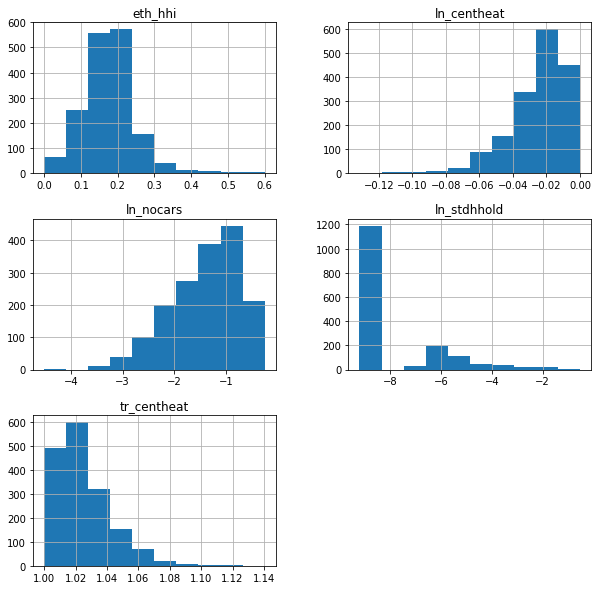

In [4]:
#transform highly skewed variables
all_data['ln_stdhhold']=np.log(all_data['studenthhold']+0.0001)
all_data.loc[all_data.eth_hhi>0.6, 'eth_hhi']=0.6
all_data['ln_nocars']=np.log(all_data['nocars']+0.001)
all_data['ln_centheat']=np.log(all_data['centheat'])
all_data['tr_centheat']=1/(all_data['centheat'])
all_data[['ln_stdhhold','eth_hhi','ln_nocars','ln_centheat','tr_centheat']].hist(figsize=(10,10))

In [5]:
#Scale the data to fit between 0 and 1. This will be useful for the K-Means analysis, as euclidian distance is used. 

to_keep=['age_median','badhealth','centheat','ln_stdhhold','onefam_hhold','eth_hhi','depr_2+','ln_nocars']

min_max_scaler=preprocessing.MinMaxScaler()
data_mm=pd.DataFrame(min_max_scaler.fit_transform(all_data[to_keep]))
data_mm.index=all_data.index

to_keep_mm=[]
for var in to_keep:
    to_keep_mm.append(var+'_mm')
data_mm.columns=to_keep_mm

all_data=all_data.join(data_mm)

#create Manchester df with only variables of interest
man_data=all_data[to_keep_mm]
appendix_a_data = man_data #used in appendix a

#show data
man_data.head()

,age_median_mm,badhealth_mm,centheat_mm,ln_stdhhold_mm,onefam_hhold_mm,eth_hhi_mm,depr_2+_mm,ln_nocars_mm
GEO_CODE,,,,,,,,
E01004766,0.615385,0.376134,0.489407,0.300378,0.514805,0.293574,0.441387,0.818313
E01004767,0.538462,0.238533,0.661732,0.536104,0.580411,0.287281,0.303776,0.731432
E01004768,0.615385,0.072416,0.932906,0.000000,0.906506,0.368692,0.058066,0.335644
E01004769,0.628205,0.167600,0.857779,0.000000,0.699100,0.329059,0.155572,0.588581
E01004770,0.692308,0.271870,0.828670,0.000000,0.820322,0.227588,0.256180,0.608170


  
Means and standard deviations of variables used in the cluster analysis are displayed below.  


In [6]:
man_data.describe().loc[['mean','std'],:]

,age_median_mm,badhealth_mm,centheat_mm,ln_stdhhold_mm,onefam_hhold_mm,eth_hhi_mm,depr_2+_mm,ln_nocars_mm
mean,0.509456,0.334304,0.801723,0.133488,0.650140,0.296840,0.413918,0.731591
std,0.168003,0.146837,0.134003,0.228213,0.158168,0.121509,0.210763,0.155601


## Cluster analysis

The cluster analysis is done on the above variables, except crime rate. It is an unsupervised technique to check for clusters within the data.  
The data will be split into two clusters. For a detailed explanation for the number of clusters used see appendix A.  


### Adding crime rates as an exploratory split
As 2 clusters seem to be a good fit for the current data, a median split is done on the rate of violent and sexual crime across LSOAs. This is done to see whether clusters also appear to represent have a relationship with crime rates. This is done out of interest to see if above and below median crime rates align with the clusters created. An alignment would hint at a relationship between clustered variables and crime rates.  


In [7]:
#do median split for crime count
to_keep_mm.append('vi_crime_count')
spatial_data=lsoa_data.join(all_data[to_keep_mm], how='right')

spatial_data['crime_cat']='Below Median'
spatial_data.loc[spatial_data.vi_crime_count>=spatial_data.vi_crime_count.median(), 'crime_cat']='Above Median'

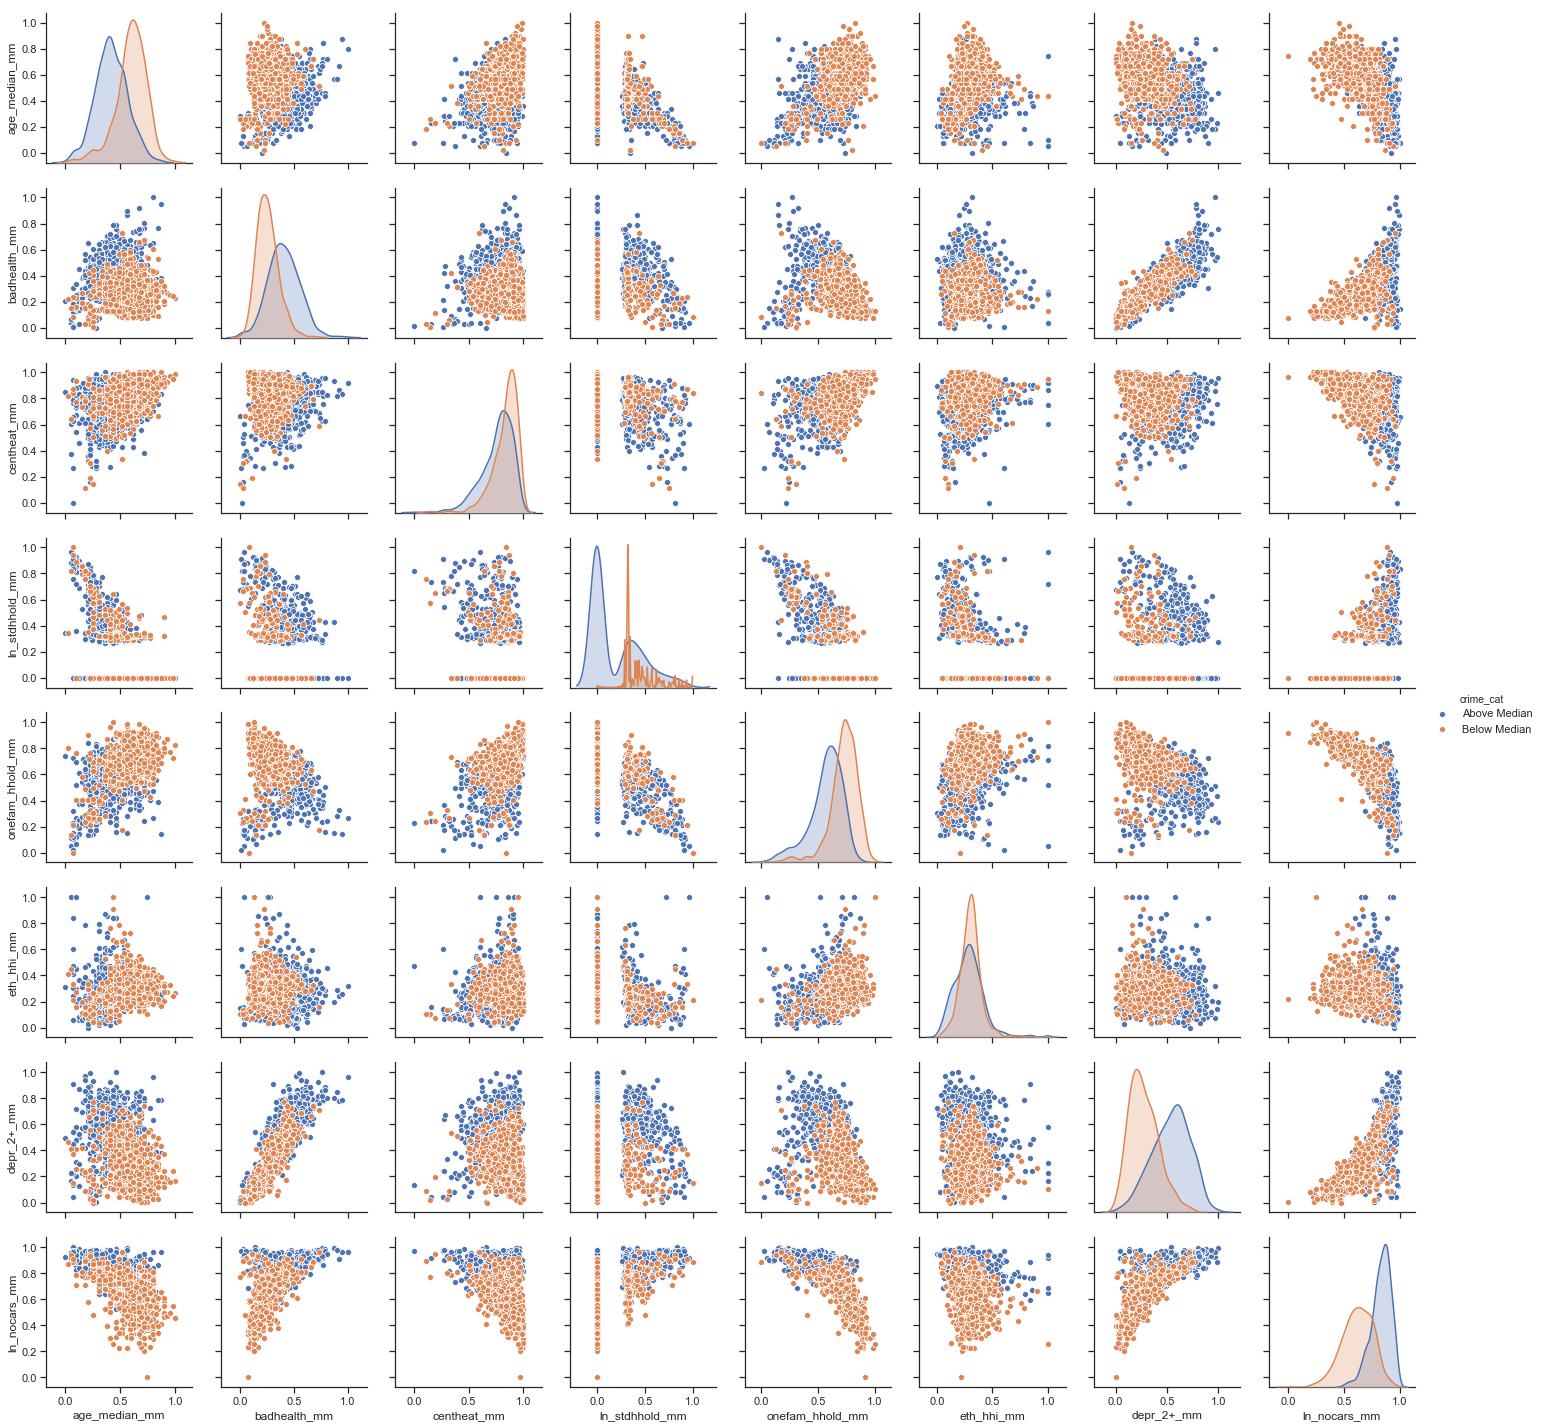

In [8]:
#add median split variable to other data and visualise the relationships between variables by crime rate median split
to_keep_mm[-1]='crime_cat'

man_data=spatial_data[to_keep_mm]
sns.set(style="ticks")
sns.pairplot(man_data, hue='crime_cat')

  
Though there are differences between scatterpoints by crime rate median split for some variables, there also appears to be significant overlap. The fraction of households without cars, household deprivation in at least 2 categories, and student households appear to have the greatest differences in distribution by crime rate median split. However, these may not be the components explaining the most variance in the dataset overall.

The tables below display mean and standard deviation of the variables by crime rate median split. Means of variables indicating higher levels of deprivation in an LSOA (household deprivation, bad health, no access to cars) appear to be higher for above median crime rates and vice versa, indicating that there may be relationships between crime rates and levels of deprivation.  


In [9]:
man_data[man_data.crime_cat=='Above Median'].describe().loc[['mean','std'],:]

,age_median_mm,badhealth_mm,centheat_mm,ln_stdhhold_mm,onefam_hhold_mm,eth_hhi_mm,depr_2+_mm,ln_nocars_mm
mean,0.422268,0.407715,0.764400,0.194972,0.573549,0.288711,0.542734,0.833941
std,0.143699,0.146667,0.140717,0.256758,0.147535,0.138310,0.182968,0.088925


In [10]:
man_data[man_data.crime_cat=='Below Median'].describe().loc[['mean','std'],:]

,age_median_mm,badhealth_mm,centheat_mm,ln_stdhhold_mm,onefam_hhold_mm,eth_hhi_mm,depr_2+_mm,ln_nocars_mm
mean,0.600807,0.257387,0.840828,0.069070,0.730387,0.305356,0.278954,0.624355
std,0.140953,0.100316,0.114253,0.171813,0.125908,0.100333,0.142470,0.137193


### Raw K-Means Clusters

The raw data is analysed for clusters, using a k-means analysis. As explained earlier, it is split into 2 clusters.  


In [11]:
km2=cluster.KMeans(n_clusters=2)

np.random.seed(1234) #seed to ensure that analysis can be replicated
k2cls=km2.fit(man_data.drop('crime_cat', axis=1))

#an array with the clusters assigned to each datapoint
k2cls.labels_

array([0, 0, 1, ..., 0, 0, 0])

In [12]:
#view the size of the clusters
man_data.groupby(k2cls.labels_)\
        .size()

0    798
1    875
dtype: int64

    
The clusters appear to have similar sizes. With regards to the crime data this may be good, as a median split would have split the data into two groups of equal size. However, the actual overlap between crime rate median split data and clusters still needs to be determined.  


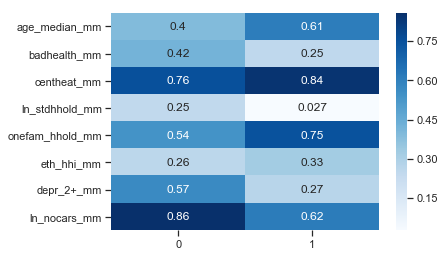

In [13]:
#means of clusters across variables higher contracts in colour indicates larger difference between means
sns.heatmap(man_data.groupby(k2cls.labels_)\
                    .mean()\
                    .T,
            annot=True,
            cmap='Blues');

In [14]:
#add cluster information to df
cluster_data=man_data.reset_index()[['GEO_CODE','crime_cat']].join(pd.Series(k2cls.labels_, name='cluster'))

cluster_data['cluster_lab']='Cluster 2'
cluster_data.loc[cluster_data.cluster < 0.5, 'cluster_lab']='Cluster 1'

cluster_2=cluster_data[['GEO_CODE','cluster_lab']].set_index('GEO_CODE')

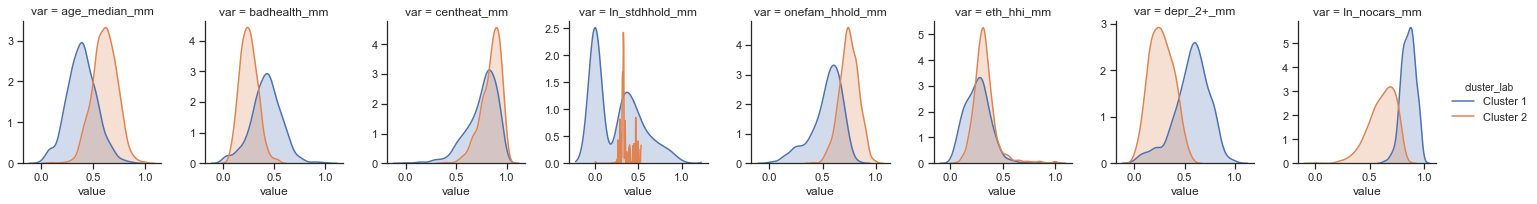

In [15]:
#plot variables by k-means clusters
tidy=man_data.drop('crime_cat', axis=1)\
             .stack()\
             .reset_index()\
             .rename(columns={0:'value','level_1':'var'})\
             .set_index('GEO_CODE')\
             .join(cluster_2)

g=sns.FacetGrid(col='var', hue='cluster_lab', data=tidy,
                  sharey=False, sharex=False, aspect=0.85)
g.map(sns.kdeplot, 'value', shade=True).add_legend();


  
The plots above display the data as split by the clusters from the k-means cluster analysis. These appear to be similar to the ones by crime rate median earlier.  


### PCA-based clusters
To check how well the clusters from the raw k-means analysis explain the variance in the data, a second k-means analysis is conducted on the two highest PCs (as these explain over 75% in the variance, see appendix A).  


In [16]:
#perform PCA using 2 components
pca=PCA(n_components=2).fit_transform(man_data.drop('crime_cat', axis=1))

#perform k-means on pca-based data (2 clusters)
k_pca=cluster.KMeans(n_clusters=2).fit(pca)

  
To visualise the clusters, colours are assigned. Moreover, the PCA-based clusters and raw clusters are displayed next to the data split by crime rate median, to explore the overlap between these clusters. Again, it should be highlighted that the comparison to the crime rate median split data is merely explorative.  


In [17]:
#create colour arrays based on the target column
colour_map={
    'Above Median':'blue',
    'Below Median':'orange',
    1:'blue',
    0:'orange'}

pca_colours=[colour_map[c] for c in k_pca.labels_]
raw_colours=[colour_map[c] for c in (1-k2cls.labels_)] #inverst to get the colours synchronised 
org_colours=[colour_map[c] for c in man_data['crime_cat']]

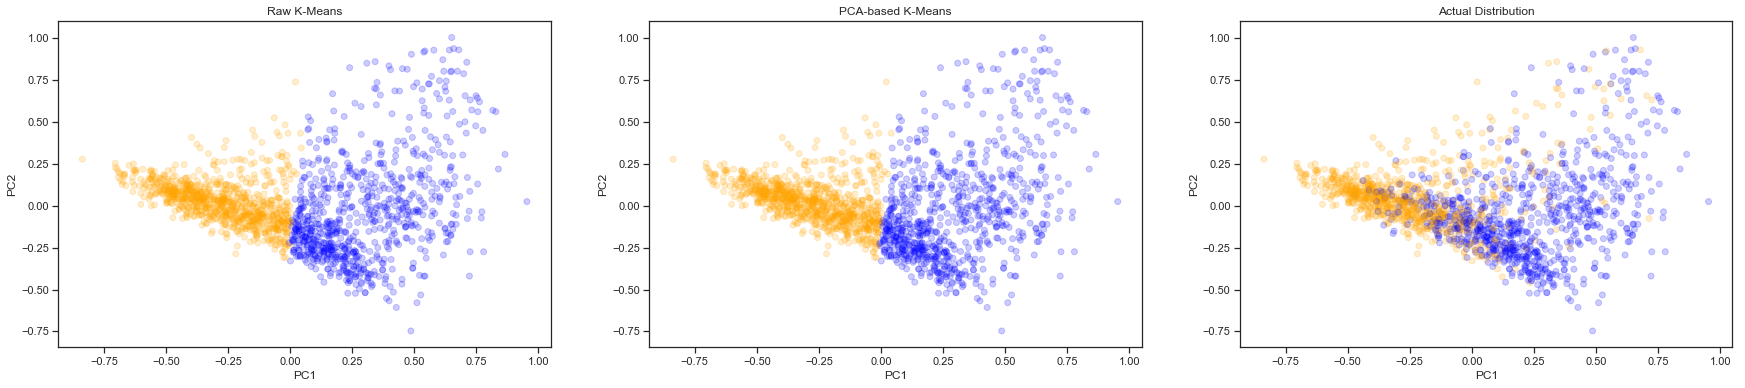

In [18]:
f,axs=plt.subplots(1,3, figsize=(30,6))

axs[0].scatter(pca[:,0], pca[:,1], 
               c=raw_colours,
               alpha=0.2);
axs[0].set_title('Raw K-Means')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')

axs[1].scatter(pca[:,0], pca[:,1], 
               c=pca_colours,
               alpha=0.2);
axs[1].set_title('PCA-based K-Means')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

axs[2].scatter(pca[:,0], pca[:,1], 
               c=org_colours,
               alpha=0.2);
axs[2].set_title('Actual Distribution')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')

plt.show()

  
The PCA-based and raw clusters appear to be very similar. Moreover, there seems to be some overlap with the crime rate split. The spatial distribution of these is displayed below.  


In [19]:
#add PCA-based K-means clusters to df
cluster_pca=man_data.reset_index()[['GEO_CODE','crime_cat']].join(pd.Series(k_pca.labels_, name='cluster'))

cluster_pca['cluster_lab']='Cluster 1'
cluster_pca.loc[cluster_pca.cluster < 0.5, 'cluster_lab']='Cluster 2'

cluster_pca_2=cluster_data[['GEO_CODE','cluster_lab']].set_index('GEO_CODE')

Text(0.5, 1.0, 'Median Split Crime Distribution')

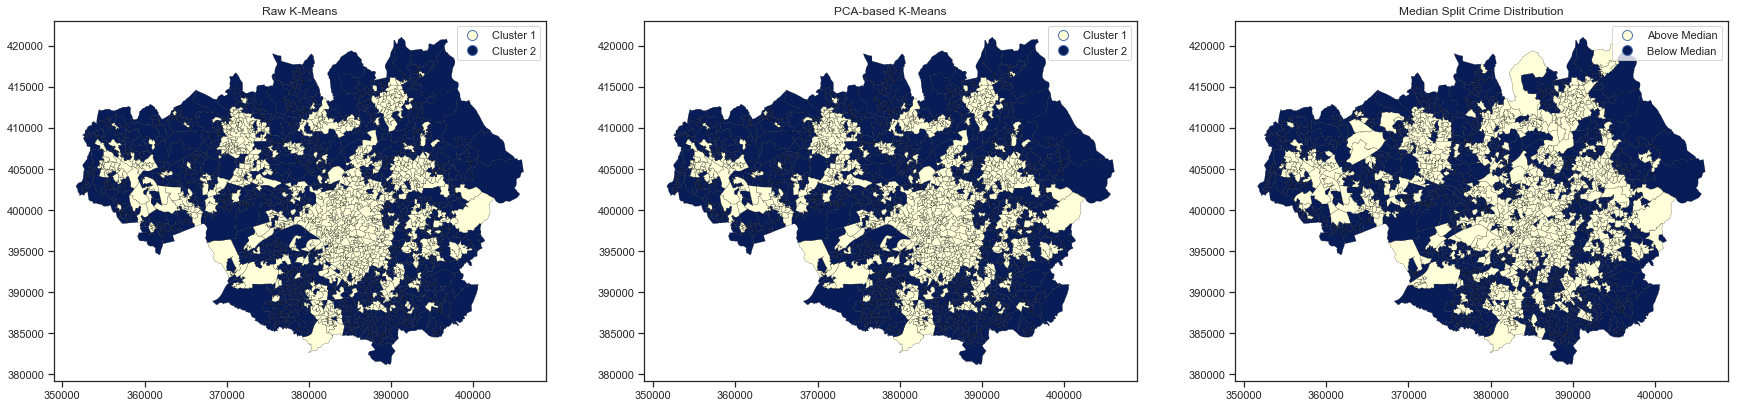

In [20]:
#view spatial distribution

fig,(ax1,ax2,ax3)=plt.subplots(nrows=1, ncols=3, figsize=(30,15))

spatial_data.join(cluster_2, how='right')\
            .plot(ax=ax1,
                  column='cluster_lab', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
            )\
            .set_title("Raw K-Means")

spatial_data.join(cluster_pca_2, how='right')\
            .plot(ax=ax2,
                  column='cluster_lab', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("PCA-based K-Means")

spatial_data.plot(ax=ax3,
                  column='crime_cat', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Median Split Crime Distribution")

### Evaluating the results

To evaluate the results of the cluster analysis, the Calinski Harabaz Scores of the raw and PCA-based clusters are compared. The raw analysis performed better than the PCA-based analysis (higher CHS), though the difference is negligble.  


In [21]:
#Comparing solutions
chs_raw=metrics.calinski_harabaz_score(man_data.drop('crime_cat', axis=1), k2cls.labels_)
chs_pca=metrics.calinski_harabaz_score(man_data.drop('crime_cat', axis=1), k_pca.labels_)

pd.Series({'0-CHS-Raw':chs_raw,
           '1-CHS-PCA':chs_pca})

0-CHS-Raw    943.335050
1-CHS-PCA    943.295571
dtype: float64

  
Moreover, the extent to which the clusters identified by the two k-means analyses match the crime rate median split distribution is estimated. It is important to note, once more, that a cluster analysis is unsupervised, and that the current cluster analyses are not looking for crime rates. This is merely and exploration to see if the clusters match the median crime groups. For this it is assumed that 'Cluster 1' matches onto 'Above Median' and 'Cluster 2' onto 'Below Median'. As shown below, 80.9% of the points match the crime median split for the raw k-means analysis, while 80.8% of points match in the PCA-based analysis. This suggests that there may be a relationship between the variables clustered here and median-split crime rates.  


In [22]:
#show crosstab to see how many were correct / incorrect
pd.crosstab(cluster_data.crime_cat, cluster_data.cluster_lab)

cluster_lab,Cluster 1,Cluster 2
crime_cat,,
Above Median,667,189
Below Median,131,686


In [23]:
#show crosstab to see how many were correct / incorrect - Raw
pd.crosstab(cluster_pca.crime_cat, cluster_pca.cluster_lab)

cluster_lab,Cluster 1,Cluster 2
crime_cat,,
Above Median,669,187
Below Median,134,683


In [24]:
#Percentage Crosstabs
crosstab_km=pd.crosstab(cluster_data.crime_cat, cluster_data.cluster_lab).apply(lambda r:r/len(cluster_data)*100, axis=1)
crosstab_pca=pd.crosstab(cluster_pca.crime_cat, cluster_pca.cluster_lab).apply(lambda r:r/len(cluster_data)*100, axis=1)

#Calculate accuracy scores, if assumed that CLuster 1 is 'Above Median' and Cluster 2 is 'Below Median'
print('Raw K-Means:',(crosstab_km.loc['Above Median']['Cluster 1'] + crosstab_km.loc['Below Median']['Cluster 2']),'\n'+ 
      'PCA-based K-Means:',(crosstab_pca.loc['Above Median']['Cluster 1'] + crosstab_pca.loc['Below Median']['Cluster 2']))

Raw K-Means: 80.8726838015541 
PCA-based K-Means: 80.81291093843396


## Regression

A regression analysis is applied to the same dataset to see how well some of the variables can predict crime rate. For this, crime rate is log-transformed, to have a more normal distribution.  


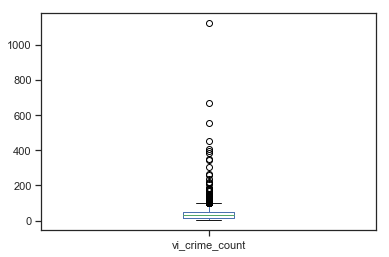

In [25]:
spatial_data['vi_crime_count'].plot(kind='box')

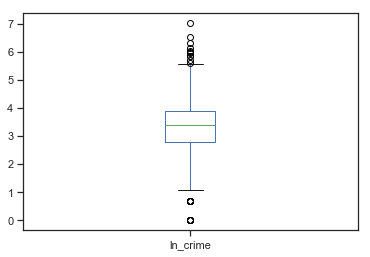

In [26]:
#log-transform data
spatial_data['ln_crime']=np.log(spatial_data['vi_crime_count'])
spatial_data['ln_crime']=spatial_data['ln_crime'].fillna(spatial_data['ln_crime'].mean())
spatial_data['ln_crime'].plot(kind='box')

Text(0.5, 1.0, 'Ln of Crime Count across Manchester LSOAs')

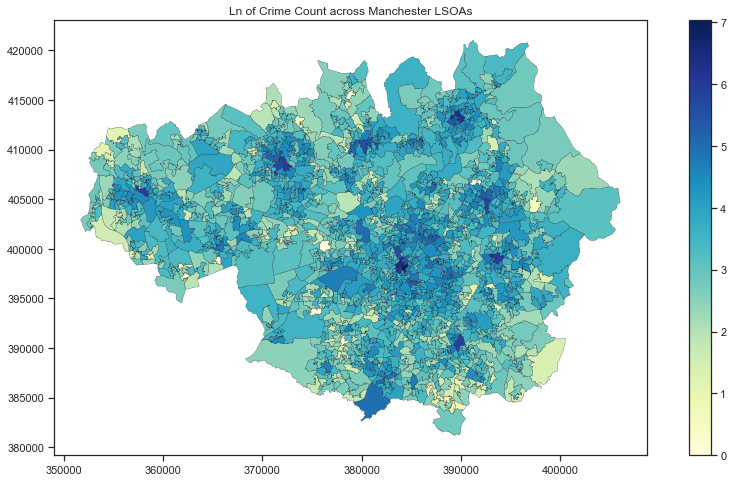

In [27]:
#Map with (trimmed) crime counts
fig,(ax)=plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

spatial_data.plot(ax=ax,
                  column='ln_crime', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
                 )\
            .set_title("Ln of Crime Count across Manchester LSOAs")

  
The log-transformed crime rates are joined to a dataframe. Moreover, the correlation between predictor variables is analysed (see colourful table below). As there are high levels of co-variance between the variables, most are not used in the regression analysis. Age and bad health are strongly correlated with crime rate, without being strongly correlated with each other. They are therefore used as a predictor variables. Moreover, ethnic diversity is only weakly correlated with these two variables and is therefore added as a predictor variable.  


In [28]:
to_keep_mm.append('ln_crime')
man_data=spatial_data[to_keep_mm].drop('crime_cat', axis=1)
man_data.columns=man_data.columns.str.replace("+","")
man_data.head()

,age_median_mm,badhealth_mm,centheat_mm,ln_stdhhold_mm,onefam_hhold_mm,eth_hhi_mm,depr_2_mm,ln_nocars_mm,ln_crime
GEO_CODE,,,,,,,,,
E01004766,0.615385,0.376134,0.489407,0.300378,0.514805,0.293574,0.441387,0.818313,3.433987
E01004767,0.538462,0.238533,0.661732,0.536104,0.580411,0.287281,0.303776,0.731432,3.663562
E01004768,0.615385,0.072416,0.932906,0.000000,0.906506,0.368692,0.058066,0.335644,1.945910
E01004769,0.628205,0.167600,0.857779,0.000000,0.699100,0.329059,0.155572,0.588581,2.833213
E01004770,0.692308,0.271870,0.828670,0.000000,0.820322,0.227588,0.256180,0.608170,2.564949


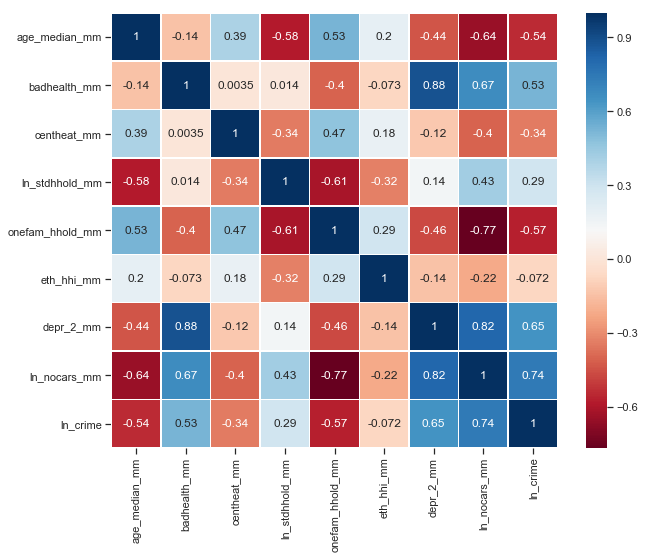

In [29]:
plt.subplots(figsize=(10,8))
sns.heatmap(man_data.corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()

### Model without cross-validation

Two models are constructed. One with and one without ethnic diversity. As the correlation between ethnic diversity and crime rate is very weak, the effect this variable makes to the overall model fit can be tested by adding it separately and comparing the models.  


In [30]:
m1=sm.ols('ln_crime ~ age_median_mm + badhealth_mm', man_data).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_crime   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     850.3
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          2.17e-255
Time:                        15:18:52   Log-Likelihood:                -1547.4
No. Observations:                1673   AIC:                             3101.
Df Residuals:                    1670   BIC:                             3117.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.6594      0.063     58.297      0.000       3.536       3.782
age_median_mm    -2.4709      0.090    -27.515      0.000      -2.647      -2.295
badhealth_mm      2.7245      0.103     26.516      0.000       2.523       2.926
==============================================================================
Omnibus:                      114.845   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              541.400
Skew:                           0.038   Prob(JB):                    2.73e-118
Kurtosis:                       5.786   Cond. No.                         9.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
m1b=sm.ols('ln_crime ~ age_median_mm + badhealth_mm + eth_hhi_mm', man_data).fit()
m1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_crime   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     573.8
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          3.33e-256
Time:                        15:18:52   Log-Likelihood:                -1542.0
No. Observations:                1673   AIC:                             3092.
Df Residuals:                    1669   BIC:                             3114.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.5609      0.069     51.305      0.000       3.425       3.697
age_median_mm    -2.5273      0.091    -27.721      0.000      -2.706      -2.348
badhealth_mm      2.7402      0.103     26.718      0.000       2.539       2.941
eth_hhi_mm        0.4107      0.125      3.282      0.001       0.165       0.656
==============================================================================
Omnibus:                      123.602   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              616.738
Skew:                           0.080   Prob(JB):                    1.19e-134
Kurtosis:                       5.970   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Performance

The performance of both models and all variables is now evaluated.  


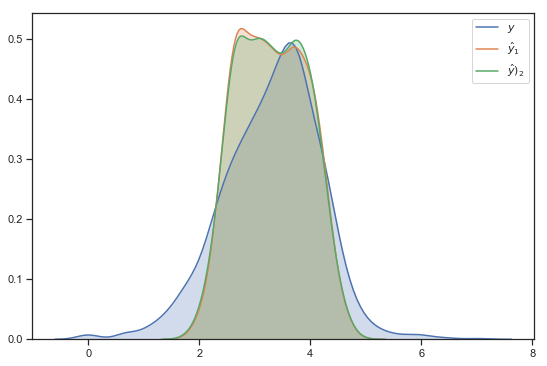

In [32]:
#compare distributions of predicted and actual values for both models 
f,ax=plt.subplots(1, figsize=(9, 6))
sns.kdeplot(man_data['ln_crime'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}_1$')
sns.kdeplot(m1b.fittedvalues, shade=True, ax=ax, label='$\hat{y})_2$')

plt.show()

In [33]:
#create df with model performance for easier comparison
r2=pd.Series({'m1':metrics.r2_score(man_data['ln_crime'], m1.fittedvalues),
                'm1b':metrics.r2_score(man_data['ln_crime'], m1b.fittedvalues)}) # R^2
mae=pd.Series({'m1':metrics.mean_squared_error(man_data['ln_crime'], m1.fittedvalues),
                 'm1b':metrics.mean_squared_error(man_data['ln_crime'], m1b.fittedvalues)}) # Mean Squared Error
mse=pd.Series({'m1':metrics.mean_absolute_error(man_data['ln_crime'], m1.fittedvalues),
                 'm1b':metrics.mean_absolute_error(man_data['ln_crime'], m1b.fittedvalues)}) # Mean Absolute Error

perf=pd.DataFrame({'MAE':mae, 'MSE':mse, 'R^2':r2})
perf

,MAE,MSE,R^2
m1,0.372297,0.451210,0.504535
m1b,0.369909,0.448586,0.507713


  
As expected, the model containing ethnic diversity is able to explain only marginally more variance in the log-transformed crime rates than the model without ethnic diversity. Though all predictor variables significantly predict crime rate, ethnic diversity is not able to explain much variance in the crime rate. Therefore, the model containing only age and bad health is used as a baseline for the further analysis.  


### Model with cross-validation

A training and testing set are created from the data. The training set will be used to build a model, while the testing set will be used to test how well the model performs on the test data. The split chosen is 80% training and 20% testing. This is commonly done to avoid overfitting and to check how well the model actually performs as a predictor.  


In [34]:
#make training and testing datasets
x_train, x_test, y_train, y_test=train_test_split(man_data[['age_median_mm', 'badhealth_mm']], man_data['ln_crime'], test_size= 0.2, random_state=1234)

In [35]:
#Train a model
m1_f='ln_crime ~ age_median_mm + badhealth_mm'
m1_tr=sm.ols(m1_f, x_train.assign(ln_crime=y_train)).fit()

In [36]:
#Compare baseline model (m1) with the trained model outputs
pd.DataFrame({'Full Dataset':m1.params,
              'Train Set':m1_tr.params})

,Full Dataset,Train Set
Intercept,3.659377,3.630410
age_median_mm,-2.470940,-2.424691
badhealth_mm,2.724467,2.795853


The train set and full dataset appear to be similar in terms of intercepts and coefficients. Hence, the models are very similar. 

In [37]:
#Now Test on the Test Data
y_pred=m1_tr.predict(x_test)

#Compare R-squared statistics
pd.Series({'0-Full Dataset':m1.rsquared,
           '1-Train Set':m1_tr.rsquared,
           '2-Test Set':metrics.r2_score(y_test, y_pred)})

0-Full Dataset    0.504535
1-Train Set       0.502501
2-Test Set        0.507774
dtype: float64

  
The full dataset model (m1) performed very similarly to the testing model. As typical (due to the difference in dataset sizes) the test set performed slightly better than the train set, though the model perfromacne is comparable. This consistency in R-squared suggests that the full and training models are not overfitted to the data.

To further check the model accuracy, 10 models are created from random samples of the dataset. As shown below their R-squared are also similar to the R-squared of m1, the test model, and the trained data on the test model. Moreover, the average R-squared is at 0.5, suggesting a high amount of variance in log-transformed crime rates explained by age and bad health.  


In [38]:
rids=np.arange(man_data.shape[0])
np.random.shuffle(rids)
r2s=model_selection.cross_val_score(LinearRegression(),
                                    man_data.iloc[rids,:][['age_median_mm','badhealth_mm']],
                                    man_data.iloc[rids,:]['ln_crime'],
                                    cv=10,
                                    scoring='r2')
print(r2s)
r2s.mean()

[0.47085479 0.51424318 0.54920468 0.45086269 0.50599263 0.55064762
 0.47954878 0.45417882 0.55123661 0.445399  ]


0.4972168797852764

### Random Forest

An alternative technique is a random forest regression. This checks for more dependencies than a linear regression model and may thuse be better (Oliveira et al., 2012). To check this on the current model, a random forest regression is done with and without cross-validation.  


In [39]:
#random forest regression model on full dataset
m2=RandomForestRegressor().fit(man_data[['age_median_mm','badhealth_mm']], man_data['ln_crime'])\
                          .predict(man_data[['age_median_mm','badhealth_mm']])

#results from m2
rf=pd.Series({'R^2':metrics.r2_score(man_data['ln_crime'], m2),
              'MSE':metrics.mean_squared_error(man_data['ln_crime'], m2),
              'MAE':metrics.mean_absolute_error(man_data['ln_crime'], m2)})

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
#random forest regression model with cross-validation
m2_cv=RandomForestRegressor().fit(x_train, y_train)\
                             .predict(x_test)

#results from m2_cv
rf_cv=pd.Series({'R^2':metrics.r2_score(y_test, m2_cv), 
                 'MSE':metrics.mean_squared_error(y_test, m2_cv),
                 'MAE':metrics.mean_absolute_error(y_test, m2_cv)})

#bind with previous models and display
pd.concat([perf, pd.DataFrame({'RF':rf}).T, pd.DataFrame({'RF-CV':rf_cv}).T], sort=True)

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,MAE,MSE,R^2
m1,0.372297,0.451210,0.504535
m1b,0.369909,0.448586,0.507713
RF,0.202426,0.081575,0.891438
RF-CV,0.513786,0.470905,0.365187


  
The results show a large difference in R-squared, mean squared error and mean absolute error between the random forest regression model with and without cross validation. This suggests that the non-cross-validated modal (m2/RF) is overfitted to the data and highlights the significance of cross-validation. The randomly selected testing sub-sample does not match the model made with the training data well. Again, the cross-validation is run multiple times (see below). The R-square scores are more comparable to RF-CV than to RF, suggesting that RF is overfitted and that the much lower R-square found in RF-CV is likely a more accurate representation of the variance explained in crime rates by fraction of households with bad health and LSOA median age. 
Nonetheless, an R-squared of 0.37 (from RF-CV), and the average R-squared from the 10 iterations of cross-validation of 0.34 suggest a good model fit. These indicate that the fraction of people with bad health and median age are able to explain 37% and 34% (respectively) of the variance in log-transformed crime rates in Greater Manchester's LSOAs.  

Considering model performance, however, in this case the rendom forest regression was unable to perform better than the linear regression model.


In [41]:
rids=np.arange(man_data.shape[0])
np.random.shuffle(rids)
r2s=model_selection.cross_val_score(RandomForestRegressor(),
                                    man_data.iloc[rids,:][['age_median_mm','badhealth_mm']],
                                    man_data.iloc[rids,:]['ln_crime'],
                                    cv=10,
                                    scoring='r2')

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "

In [42]:
print(r2s)
r2s.mean()

[0.31024467 0.33126121 0.30649621 0.34799421 0.45620162 0.28505996
 0.38815051 0.27310348 0.40405792 0.30689597]


0.34094657522275573

## Conclusion

In line with Tarling and Dennis (2016), the current analysis finds rates of violent and sexual crime to be positively related to measures of deprivation, in particular measures of poor health. Moreover, an LSOA's median age is significantly and negatively related to rates of violent and sexual crime. 

## References

1. de Vocht, F., Heron, J., Mooney, J., Angus, C., Lock, K., Egan, M., Campbell, R., Brennan, A., and Hickman, M. (2016) Cross-sectional and longitudinal associations between alcohol licensing policies, outlet density and deprivation and population health and crime in England. _Journal of Epidemology & Community Health, 70_, A83.  
2. Eberts, P., and Schwirian, K.P. (1968) Metropolitan Crime Rates and Relative Deprivation, _Criminologica, 5_, 43-52.   
3. Kawachi, I., Kennedy, B.P., and Wilkinson, R.G. (1999) Crime: social disorganization and relative deprivation. _Social Science & Medicine, 48_, 719-731. 
4. Office for National Statistics (2011) Census: Digitised Boundary Data (England and Wales) [computer file]. UK Data Service Census Support. Downloaded from: https://borders.ukdataservice.ac.uk/
5. Office for National Statistics (2016) 2011 Census aggregate data. UK Data Service (Edition: June 2016).
6. Oliviera S., Oehler, F., San-Miguel-Ayanz, J., Camia, A., and Pereira, J.M.C. (2012) Modeling spatial patterns of fire occurrence in Mediterranean Europe using Multiple Regression and Random Forest. _Forest Ecology and Management, 275_(1), 117-129. 
7. Tarling, R. and Dennis, R. (2016) Socio‐Economic Determinants of Crime Rates: Modelling Local Area Police‐Recorded Crime. _The Howard Journal of Crime and Justice, 55_(1), 207-225.
8. UK Crime Stats (nd) All LSOA. UK Crime Stats: The leading crime and postcode data research and analysis platform. Downloaded from: https://www.ukcrimestats.com/LSOA/

## Appendix A - Finding the right number of clusters and principle components

The number of clusters used in the current analysis is determined by the elbow method. First, a principle components analysis (PCA) is performed on the data. A K-means cluster analysis is then applied for 1 to 10 clusters and the WCSS is calculated for each of these, to determine which number of clusters should be used. Ideally, the WCSS should be as low as possible, while the number of clusters should also be as low as possible. 

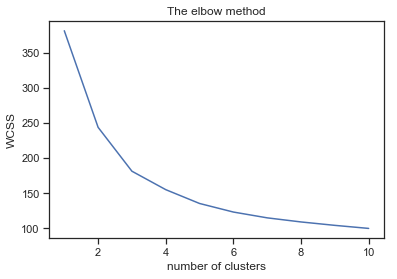

In [43]:
#Create an instance of PCA class
pca=PCA(n_components=None) 

#Fit the data to the model
pcaResults=pca.fit_transform(appendix_a_data)
explained_variance=pca.explained_variance_ratio_ # Extract the varience

#use the elbow method
wcss=[]

for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pcaResults)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS results
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()


The 'sweet spot' between low WCSS and few clusters appears to be around 2 clusters. Thus, this number will be used in the K-Means analysis. 
Moreover, the variance explained by each principal component (PC) is printed below. The first two PCs explain over 75% of the variance in the data. Therefore, 2 PCs will be used to the PCA part of the current analysis.  

In [44]:
#Show how much variance each PC explains
print(np.around(explained_variance, 3))

[0.512 0.247 0.075 0.066 0.053 0.032 0.01  0.007]
